# Sequencing coverage analysis
Copyright 2023 John Shin under GPL-3.0

Supporting Figures come from this document.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

Import some data

In [2]:
data_path = 'Data/'

In [3]:
wt_df = pd.read_pickle(data_path+'wt_df.pkl')
wt_df.head(2)

variant
seq          scaffold         
UAUGG_CCUAAG 13854       21164
             35600       27726

In [4]:
single_mutant_df = pd.read_pickle(data_path+'single_mutant_df.pkl')
single_mutant_df.head(2)

mutations  \
seq          scaffold                                      
UAUGG_ACUAAG 13854     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]   
             35600     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]   

                       mutation_reorder_loc mutation_res loc_res variant  
seq          scaffold                                                     
UAUGG_ACUAAG 13854                        1            A    [1A]   21099  
             35600                        1            A    [1A]   27661

In [5]:
double_mutant_df = pd.read_pickle(data_path+'double_mutant_df.pkl')
double_mutant_df.head(2)

mutations mutation_reorder_loc  \
             scaffold                                                           
UAUGG_AAUAAG 13854     [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]               [1, 2]   
             35600     [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]               [1, 2]   

                      mutation_res   loc_res first_mut second_mut  \
             scaffold                                               
UAUGG_AAUAAG 13854          [A, A]  [1A, 2A]         A          A   
             35600          [A, A]  [1A, 2A]         A          A   

                       first_mut_loc  second_mut_loc variant  
             scaffold                                         
UAUGG_AAUAAG 13854                 1               2   21093  
             35600                 1               2   27655

In [6]:
single_mutant_df = single_mutant_df.rename(columns={
    'mutation_reorder_loc':'first_loc',
    'mutation_res':'first_res'
})
single_mutant_df['second_loc'] = None
single_mutant_df['second_res'] = None

double_mutant_df = double_mutant_df.rename(columns={
    'first_mut_loc':'first_loc',
    'first_mut':'first_res',
    'second_mut_loc':'second_loc',
    'second_mut':'second_res'
})
all_mut_df = pd.concat((wt_df,single_mutant_df,double_mutant_df))

In [7]:
wt_variants = wt_df['variant']
single_muts_variants = single_mutant_df['variant']
double_muts_variants = double_mutant_df['variant']

In [21]:
dG_GAAA_wt_df = pd.read_pickle(data_path+'dGs/dG_GAAA_wt_df.pkl')
dG_GAAA_single_df = pd.read_pickle(data_path+'dGs/dG_GAAA_single_df.pkl')
dG_GAAA_double_df = pd.read_pickle(data_path+'dGs/dG_GAAA_double_df.pkl')

dG_GUAA_wt_df = pd.read_pickle(data_path+'dGs/dG_GUAA_wt_df.pkl')
dG_GUAA_single_df = pd.read_pickle(data_path+'dGs/dG_GUAA_single_df.pkl')
dG_GUAA_double_df = pd.read_pickle(data_path+'dGs/dG_GUAA_double_df.pkl')

Cluster coverage for variants

In [8]:
GUAA_wt_df = wt_df.copy()
GUAA_single_mutant_df = single_mutant_df.copy()
GUAA_double_mutant_df = double_mutant_df.copy()

In [9]:
GUAA_CPvariant = pd.read_csv(data_path+'Mut2_GUAA_1_fmax.CPvariant',sep='\t').rename(columns={'Unnamed: 0':'variant'})
GUAA_CPvariant['variant'] = [str(int(i)) for i in GUAA_CPvariant['variant']]
GUAA_CPvariant = GUAA_CPvariant.set_index('variant')
new_GUAA_CPvariant = pd.read_csv(data_path+'missing_Mut2_GUAA_1_fmax.CPvariant',sep='\t').rename(columns={'Unnamed: 0':'variant'})
new_GUAA_CPvariant['variant'] = [str(int(i)) for i in new_GUAA_CPvariant['variant']]
new_GUAA_CPvariant = new_GUAA_CPvariant.set_index('variant')


In [10]:
combined_GUAA_CPvariant = new_GUAA_CPvariant.T.join(GUAA_CPvariant.T,how='outer',rsuffix='duplicate')
combined_GUAA_CPvariant = combined_GUAA_CPvariant.drop(combined_GUAA_CPvariant.filter(regex='duplicate').columns,axis=1)
combined_GUAA_CPvariant = combined_GUAA_CPvariant.T
combined_GUAA_CPvariant.index = combined_GUAA_CPvariant.index.astype(int)

In [11]:
combined_GUAA_CPvariant.query('num_iter < 10000 & num_tests > 5')

,fmax_init,dG_init,fmin_init,rsq_init,rmse_init,dG,dG_lb,dG_ub,fmax,fmax_lb,fmax_ub,fmin,rsq,rmse,num_iter,num_tests,fmax_enforced
variant,,,,,,,,,,,,,,,,,


In [12]:
all_GUAA_df = all_mut_df.join(combined_GUAA_CPvariant[['num_tests']],on='variant')

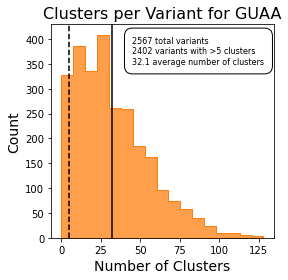

In [13]:
temp = all_GUAA_df['num_tests'].fillna(0)

fig,ax = plt.subplots(figsize=(4,4))

sns.histplot(temp,bins='doane',element='step',ax=ax,color='tab:orange')
ax.axvline(5,color='k',linestyle='--',label='n = 5')
ax.axvline(np.mean(temp),color='k',label='Mean Clusters')

ax.text(45,350,f"{sum(temp>0)} total variants\n"+\
               f"{sum(temp>5)} variants with >5 clusters\n"+\
               f"{np.mean(temp):.1f} average number of clusters",
        bbox={'boxstyle':'round','facecolor':'white','pad':1},fontsize=8)

ax.set_ylabel('Count',fontsize=14)
ax.set_xlabel('Number of Clusters',fontsize=14)
ax.set_title('Clusters per Variant for GUAA',fontsize=16)

plt.tight_layout()
plt.savefig('Figures/Supplement/Clusters_per_Variant_GUAA.png',facecolor='white',dpi=600)

plt.show()

In [15]:
GAAA_wt_df = wt_df.copy()
GAAA_single_mutant_df = single_mutant_df.copy()
GAAA_double_mutant_df = double_mutant_df.copy()

In [16]:
GAAA_1_CPvariant = pd.read_csv(data_path+'Mut2_GAAA_1_fmax.CPvariant',sep='\t').rename(columns={'Unnamed: 0':'variant'})
GAAA_1_CPvariant['variant'] = [str(int(i)) for i in GAAA_1_CPvariant['variant']]
GAAA_1_CPvariant = GAAA_1_CPvariant.set_index('variant')
new_GAAA_1_CPvariant = pd.read_csv(data_path+'missing_Mut2_GAAA_1_fmax.CPvariant',sep='\t').rename(columns={'Unnamed: 0':'variant'})
new_GAAA_1_CPvariant['variant'] = [str(int(i)) for i in new_GAAA_1_CPvariant['variant']]
new_GAAA_1_CPvariant = new_GAAA_1_CPvariant.set_index('variant')

GAAA_2_CPvariant = pd.read_csv(data_path+'Mut2_GAAA_2_fmax.CPvariant',sep='\t').rename(columns={'Unnamed: 0':'variant'})
GAAA_2_CPvariant['variant'] = [str(int(i)) for i in GAAA_2_CPvariant['variant']]
GAAA_2_CPvariant = GAAA_2_CPvariant.set_index('variant')
new_GAAA_2_CPvariant = pd.read_csv(data_path+'missing_Mut2_GAAA_2_fmax.CPvariant',sep='\t').rename(columns={'Unnamed: 0':'variant'})
new_GAAA_2_CPvariant['variant'] = [str(int(i)) for i in new_GAAA_2_CPvariant['variant']]
new_GAAA_2_CPvariant = new_GAAA_2_CPvariant.set_index('variant')


In [17]:
combined_GAAA_1_CPvariant = new_GAAA_1_CPvariant.T.join(GAAA_1_CPvariant.T,how='outer',rsuffix='duplicate')
combined_GAAA_1_CPvariant = combined_GAAA_1_CPvariant.drop(combined_GAAA_1_CPvariant.filter(regex='duplicate').columns,axis=1)
combined_GAAA_1_CPvariant = combined_GAAA_1_CPvariant.T
combined_GAAA_1_CPvariant.index = combined_GAAA_1_CPvariant.index.astype(int)

combined_GAAA_2_CPvariant = new_GAAA_2_CPvariant.T.join(GAAA_2_CPvariant.T,how='outer',rsuffix='duplicate')
combined_GAAA_2_CPvariant = combined_GAAA_2_CPvariant.drop(combined_GAAA_2_CPvariant.filter(regex='duplicate').columns,axis=1)
combined_GAAA_2_CPvariant = combined_GAAA_2_CPvariant.T
combined_GAAA_2_CPvariant.index = combined_GAAA_2_CPvariant.index.astype(int)

In [18]:
all_GAAA_1_df = all_mut_df.join(combined_GAAA_1_CPvariant[['num_tests']],on='variant')
all_GAAA_2_df = all_mut_df.join(combined_GAAA_2_CPvariant[['num_tests']],on='variant')

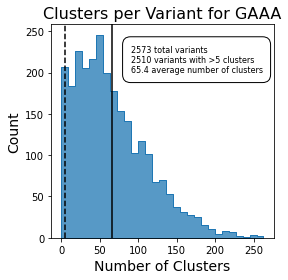

In [19]:
temp = all_GAAA_1_df['num_tests'].fillna(0)+all_GAAA_2_df['num_tests'].fillna(0)

fig,ax = plt.subplots(figsize=(4,4))

sns.histplot(temp,bins='fd',element='step',ax=ax,color='tab:blue')
ax.axvline(5,color='k',linestyle='--')
ax.axvline(np.mean(temp),color='k')

ax.text(90,200,f"{sum(temp>0)} total variants\n"+\
               f"{sum(temp>5)} variants with >5 clusters\n"+\
               f"{np.mean(temp):.1f} average number of clusters",
        bbox={'boxstyle':'round','facecolor':'white','pad':1},fontsize=8)

ax.set_ylabel('Count',fontsize=14)
ax.set_xlabel('Number of Clusters',fontsize=14)
ax.set_title('Clusters per Variant for GAAA',fontsize=16)

plt.tight_layout()

plt.savefig('Figures/Supplement/Clusters_per_Variant_GAAA.png',facecolor='white',dpi=600)

plt.show()

Scaffold Coverage for variants

In [22]:
combined_GAAA_data = pd.concat([
    dG_GAAA_wt_df.pivot_table(index='seq',columns=['scaffold'],values='dG'),
    dG_GAAA_single_df.pivot_table(index='seq',columns=['scaffold'],values='dG'),
    dG_GAAA_double_df.pivot_table(index='seq',columns=['scaffold'],values='dG')])

In [23]:
combined_GUAA_data = pd.concat([
    dG_GUAA_wt_df.pivot_table(index='seq',columns=['scaffold'],values='dG'),
    dG_GUAA_single_df.pivot_table(index='seq',columns=['scaffold'],values='dG'),
    dG_GUAA_double_df.pivot_table(index='seq',columns=['scaffold'],values='dG')])

In [24]:
pd.DataFrame({'GAAA':np.sum(~combined_GAAA_data.isna(),axis=1),
              'GUAA':np.sum(~combined_GUAA_data.isna(),axis=1)
              }).melt().value_counts().reset_index()

,variable,value,0
0,GAAA,5,423
1,GUAA,5,417
2,GUAA,4,77
3,GAAA,4,73
4,GAAA,3,28
5,GUAA,3,28
6,GUAA,2,5
7,GAAA,2,4
8,GUAA,1,2
9,GAAA,1,1


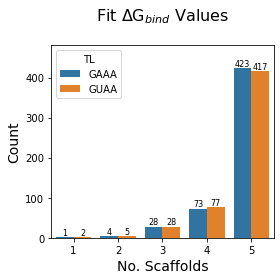

5    79.962193
4    13.799622
3     5.293006
2     0.756144
1     0.189036
dtype: float64

5    78.827977
4    14.555766
3     5.293006
2     0.945180
1     0.378072
dtype: float64

In [25]:
fig,ax=plt.subplots(figsize=(4,4))

sns.barplot(data=pd.DataFrame({
                        'GAAA':np.sum(~combined_GAAA_data.isna(),axis=1),
                        'GUAA':np.sum(~combined_GUAA_data.isna(),axis=1)
                        }).melt().value_counts().reset_index().rename(columns={
                        'value':'No. Scaffolds','variable':'TL',0:'Count'
            }),
           x='No. Scaffolds',y='Count',hue='TL')

plt.title('Fit $\Delta$G$_{bind}$ Values\n',fontsize=16)
plt.xlabel(plt.gca().get_xlabel(),fontsize=14)
plt.ylabel(plt.gca().get_ylabel(),fontsize=14)

ax.bar_label(ax.containers[1], fmt='%.0f', label_type='edge',fontsize=8)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge',fontsize=8)

ax.set_ylim((0,480))

plt.tight_layout()
plt.savefig('Figures/Supplement/Measured_Scaffolds_per_Variant.png',facecolor='white',dpi=600)
plt.show()


display(np.sum(~combined_GAAA_data.isna(),axis=1).value_counts()/529*100)
display(np.sum(~combined_GUAA_data.isna(),axis=1).value_counts()/529*100)


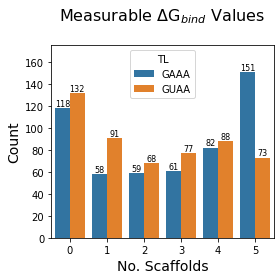

5    28.544423
4    15.500945
3    11.531191
2    11.153119
1    10.964083
0    22.306238
dtype: float64

5    13.799622
4    16.635161
3    14.555766
2    12.854442
1    17.202268
0    24.952741
dtype: float64

In [26]:
fig,ax=plt.subplots(figsize=(4,4))


sns.barplot(data=pd.DataFrame({
                        'GAAA':np.sum(combined_GAAA_data<-7.1,axis=1),
                        'GUAA':np.sum(combined_GUAA_data<-7.1,axis=1)
                        }).melt().value_counts().reset_index().rename(columns={
                        'value':'No. Scaffolds','variable':'TL',0:'Count'
            }),
           x='No. Scaffolds',y='Count',hue='TL')
plt.title('Measurable $\Delta$G$_{bind}$ Values\n',fontsize=16)

plt.xlabel(plt.gca().get_xlabel(),fontsize=14)
plt.ylabel(plt.gca().get_ylabel(),fontsize=14)


ax.bar_label(ax.containers[1], fmt='%.0f', label_type='edge',fontsize=8)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge',fontsize=8)

ax.set_ylim((0,175))

# ax.legend(loc='upper center')

plt.tight_layout()
plt.savefig('Figures/Supplement/Quantitative_Scaffolds_per_Variant.png',facecolor='white',dpi=600)
plt.show()


plt.show()



display(np.sum(combined_GAAA_data<-7.1,axis=1).value_counts().sort_index(ascending=False)/529*100)
display(np.sum(combined_GUAA_data<-7.1,axis=1).value_counts().sort_index(ascending=False)/529*100)
